S--epoch:0    MAE:8.140432999420167   Pure:0.0
S--epoch:10    MAE:4.267339051055909   Pure:0.0
Test_epoch:10    MAE_test:26.74333023071289


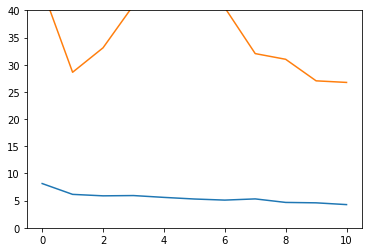

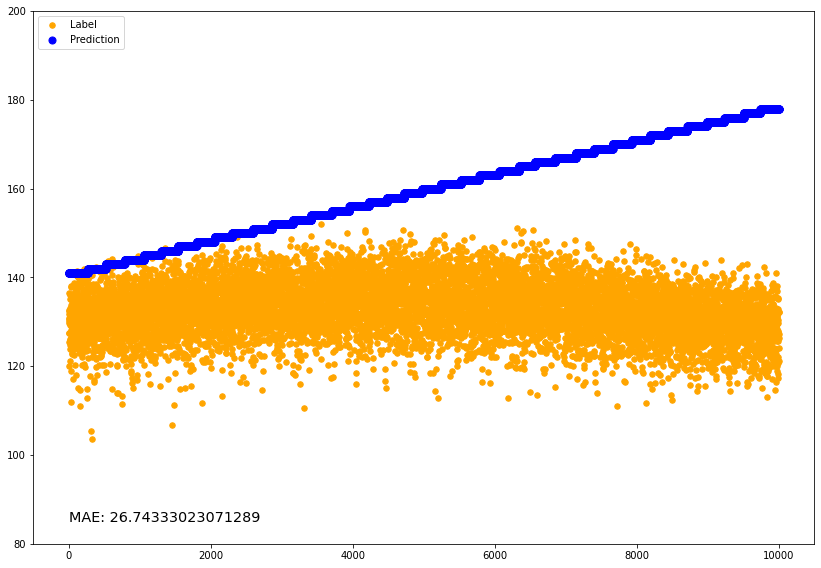

KeyboardInterrupt: 

In [1]:
import torch.optim as optim
from dataset import *
from model import *
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

s_or_d = 0
tmp = np.load("../data/simu_20000_0.1_90_140_train.npy")
if s_or_d == 0:
    max_val = np.max(tmp[:, 1004])
    min_val = np.min(tmp[:, 1004])
else:
    max_val = np.max(tmp[:, 1005])
    min_val = np.min(tmp[:, 1005])


train_log = np.array([])
test_log = np.array([])
lambda_l1 = 0

criterion = nn.L1Loss()
criterion = criterion.cuda()

model = TemporalConvNet(1,[4,4,4,4,4,1]).cuda()

optimizer = optim.Adam(model.parameters(), lr=0.01)

train_dataset = Dataset("../data/simu_20000_0.1_90_140_train.npy", 0, 0)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataset = Dataset("../data/simu_10000_0.1_141_178_test.npy", 0, 1)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

for epoch in range(500):
    model.train()

    loss_total = 0
    step = 0
    
    loss_pure = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        # target = (target - min_val)/(max_val - min_val)
        
        output = model(data)
        # print(output)
        
        loss = criterion(output, target)
        # loss_pure = loss_pure + loss.item()
        
        # l1_regularization = torch.tensor(0.0).cuda()
        # for param in model.parameters():
        #     l1_regularization += torch.norm(param, p=1)
        # loss += l1_regularization * lambda_l1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_total = loss_total + loss.item()
        step = step + 1

    tmp = './pth/S_model_%d_%.4f.pth' % (epoch, loss_total/step)
    if epoch % 10 == 0:
        # torch.save(model, tmp)
        print("S--epoch:" + str(epoch) + "    MAE:" + str(loss_total/step) + "   Pure:" + str(loss_pure/step))
    train_log = np.append(train_log, loss_total/step)

    loss_test = 0
    step = 0
    label = np.array([])
    predict = np.array([])
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.cuda(), target.cuda()
            output = model(data)
            # print(output)
            # output = output * (max_val - min_val) + min_val
            
            loss = criterion(output, target)

            loss_test = loss_test + loss.item()
            step = step + 1
            
            # 记录当前模型的
            if epoch % 10 == 0 and epoch != 0:
                label = np.append(label, target.cpu().detach().numpy().reshape((-1)))
                predict = np.append(predict,output.cpu().detach().numpy().reshape((-1)))

        loss_mean = loss_test / step
        test_log = np.append(test_log, loss_mean)
    
    if epoch % 10 == 0 and epoch != 0:
        print("Test_epoch:" + str(epoch) + "    MAE_test:" + str(loss_mean))
        # tmp_epoch = np.arange(epoch+1)
        # print(tmp_epoch)
        # print(next(model.OneToOneLayer.parameters()))
        plt.plot(train_log)
        plt.plot(test_log)
        plt.ylim(0,40)
        plt.show()
        
        sorted_index = sorted(range(len(label)), key=lambda k: label[k])
        sorted_label = [label[i] for i in sorted_index]
        sorted_predict = [predict[i] for i in sorted_index]

        MAEstr = "MAE: " + repr(loss_mean)

        plt.figure(figsize=(14,9.8))
        plt.scatter(np.arange(1,len(predict)+1),sorted_predict,c="orange", s=30)
        plt.scatter(np.arange(1,len(label)+1),sorted_label, c="blue", s=50)
        plt.legend(["Label" ,"Prediction"],loc="upper left")
        plt.text(0.1,85,MAEstr,fontsize="x-large")
        plt.ylim(80,200)
        plt.show()